# COMP0026 Image Processing
## Coursework 3-Poisson Image Editing

## Task 1
**Select a grayscale image. Mark out a region using a polygon (you can use rpoly). Remove the selected region and fill it in using Equation (2) in the paper. You are solving for unknown intensity values inside the region R. Test the method in smooth regions and also in regions with edges (high-frequency). Also report the behavior as the size of the selected region increases.**

In [1]:
#Let's import the necessary libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.sparse import linalg as linalg
from scipy.sparse import lil_matrix as lil_matrix

In [2]:
#Helper Function to create mask from an image
def select_region(img):
    image=img.copy()
    points = []
    def mouse_callback(event, x, y, flags, param):
        if event == cv2.EVENT_LBUTTONDOWN:
            points.append((x, y))

    cv2.namedWindow('Select Region')
    cv2.setMouseCallback('Select Region', mouse_callback)

    while True:
        if points:
            last_coordinate=points[-1]
            image=cv2.circle(image, last_coordinate, 5, (0, 0, 255), -1)
            
        cv2.imshow('Select Region', image)
        key = cv2.waitKey(1) & 0xFF

        if key == 27:  # Press 'Esc' to exit
            break

    cv2.destroyAllWindows()
    points=np.int32([points])
    
    mask = np.zeros_like(image)
    cv2.fillPoly(mask, np.array(points).astype(np.int32), 255)
    target_image = cv2.bitwise_and(img,cv2.bitwise_not(mask))
    source_image = cv2.bitwise_and(img,mask)
    
    if mask.shape[-1]==3:
        mask=cv2.cvtColor(mask,cv2.COLOR_BGR2GRAY)
        mask[mask > 1] = 255
    return mask,source_image,target_image


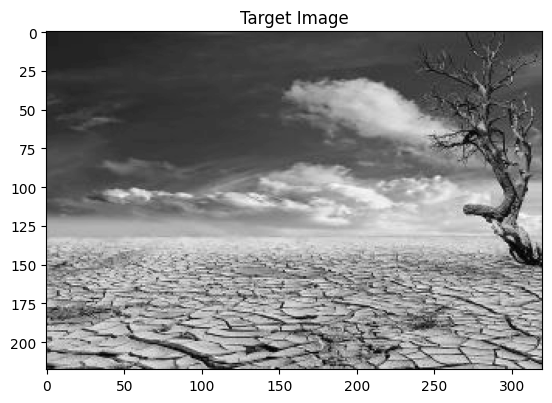

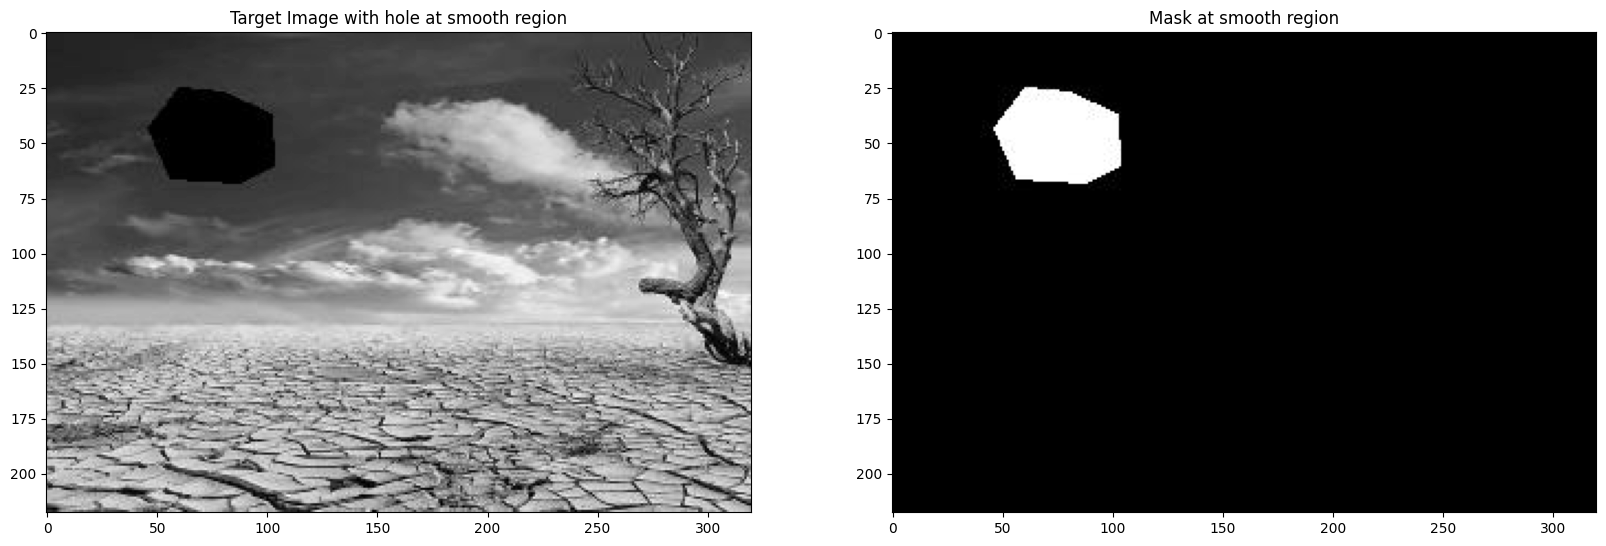

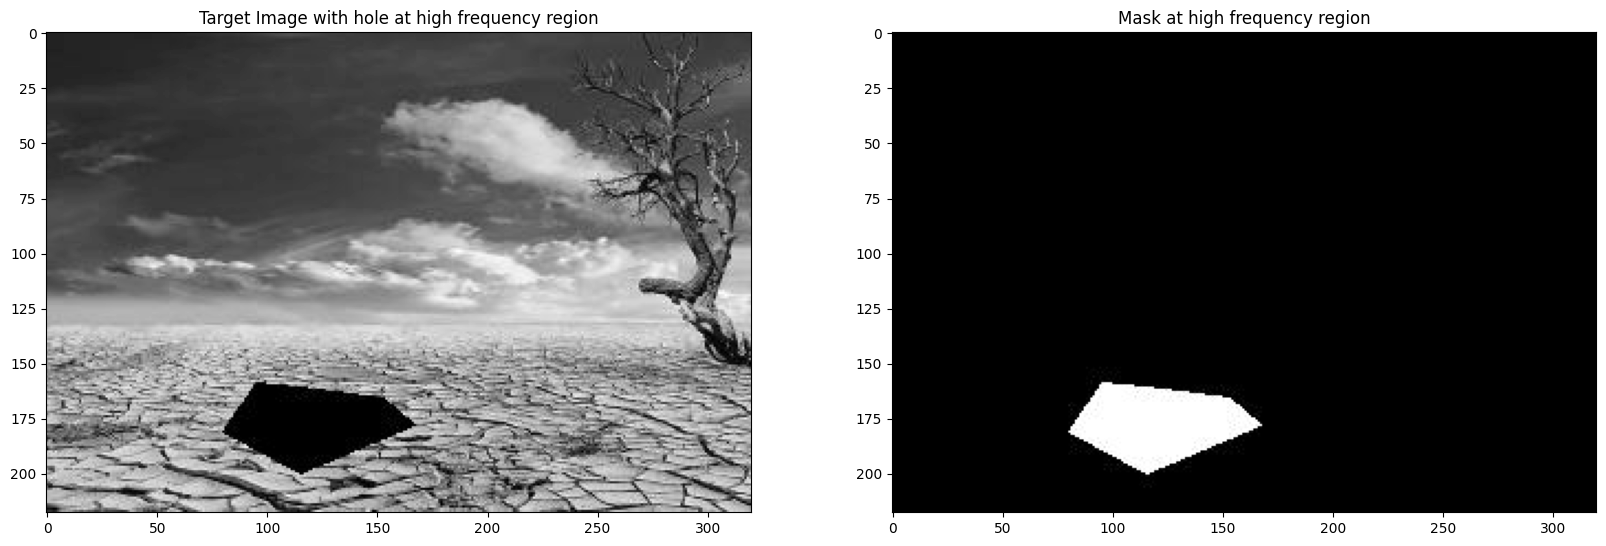

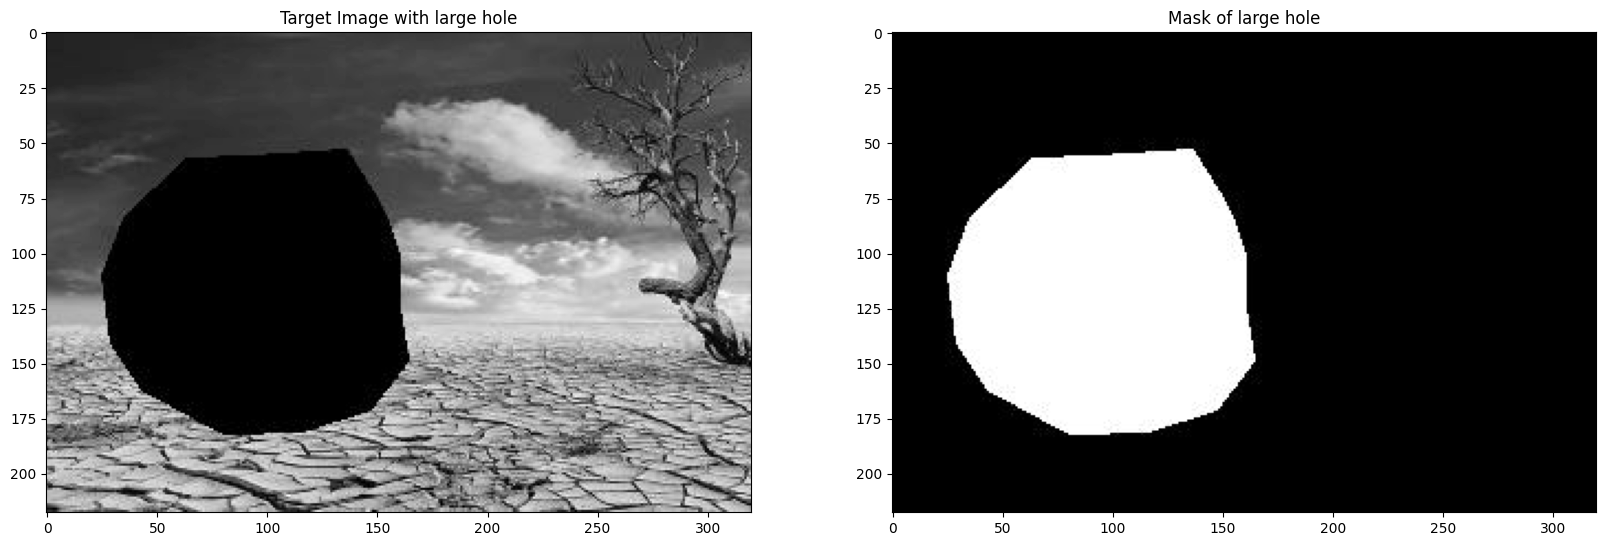

In [3]:
#Loding Image to demonstrate different senarios
img=cv2.imread('Inputs/desert1.jpg')
gray_img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
plt.imshow(gray_img,cmap='gray')
plt.title('Target Image')

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)

smoothHole=cv2.imread('Inputs/desertSmoothHole.jpg')
smoothHole=cv2.cvtColor(smoothHole,cv2.COLOR_BGR2GRAY)
plt.imshow(smoothHole,cmap='gray')
plt.title('Target Image with hole at smooth region')


smoothMask=cv2.imread('Inputs/desertSmoothMask.jpg', cv2.IMREAD_GRAYSCALE)
# smoothMask = np.atleast_3d(smoothMask).astype(np.float32) / 255.
smoothMask[smoothMask < 1] = 0
# smoothMask = smoothMask[:,:,0]

plt.subplot(1,2,2)
plt.imshow(smoothMask,cmap='gray')
plt.title('Mask at smooth region')

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
HFHole=cv2.imread('Inputs/desertHFHole.jpg')
HFHole=cv2.cvtColor(HFHole,cv2.COLOR_BGR2GRAY)
plt.imshow(HFHole,cmap='gray')
plt.title('Target Image with hole at high frequency region')

HFMask=cv2.imread('Inputs/desertHFMask.jpg', cv2.IMREAD_GRAYSCALE)
HFMask[HFMask < 1] = 0
plt.subplot(1,2,2)
plt.imshow(HFMask,cmap='gray')
plt.title('Mask at high frequency region');

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
LHole=cv2.imread('Inputs/desertLargeHole.jpg')
LHole=cv2.cvtColor(LHole,cv2.COLOR_BGR2GRAY)
plt.imshow(LHole,cmap='gray')
plt.title('Target Image with large hole')

LMask=cv2.imread('Inputs/desertLargeMask.jpg', cv2.IMREAD_GRAYSCALE)
LMask[LMask < 1] = 0
plt.subplot(1,2,2)
plt.imshow(LMask,cmap='gray')
plt.title('Mask of large hole');

In [4]:
# Helper functions to perform Poisson Image Editing

def get_mask_pixels(mask):
    nonzero = np.nonzero(mask)
    return zip(nonzero[0], nonzero[1])
def get_4_connected_pixels(pixel):
    return [(pixel[0]+1,pixel[1]),(pixel[0]-1,pixel[1]),(pixel[0],pixel[1]+1),(pixel[0],pixel[1]-1)]

def get_4_connected_pixels_flatten(pixel):
    return [(pixel[0]+2,pixel[1]),(pixel[0]-2,pixel[1]),(pixel[0],pixel[1]+2),(pixel[0],pixel[1]-2)]

def get_laplacian(source,pixel): 
    i,j = pixel
    val=[0,0,0,0]
    val[0]=1.*source[i,j]-1.*source[i+1, j]
    val[1]=1.*source[i,j]-1.*source[i-1, j]
    val[2]=1.*source[i,j]-1.*source[i, j+1]
    val[3]=1.*source[i,j]-1.*source[i, j-1]
    return sum(val)

def get_laplacian_flatten(source,pixel,M): 
    i,j = pixel
    val=[0,0,0,0]
    
    if M[i+1, j]>0 or M[i, j]>0:
        val[0]=1.*source[i,j]-1.*source[i+1,j]

        
    if M[i-1, j]>0 or M[i, j]>0:
        val[1]=1.*source[i,j]-1.*source[i-1,j]

        
    if M[i, j+1]>0 or M[i, j]>0:
        val[2]=1.*source[i,j]-1.*source[i,j+1]

        
    if M[i, j-1]>0 or M[i, j]>0:
        val[3]=1.*source[i,j]-1.*source[i,j-1]

    return sum(val)

def get_laplacian_mixed(source,target,pixel): 

    i,j = pixel
    val=[0,0,0,0]
    
    if abs(1.*source[i,j]-1.*source[i+1,j])>abs(1.*target[i,j]-1.*target[i+1,j]):
        val[0]=1.*source[i,j]-1.*source[i+1,j]
    else:
        val[0]=1.*target[i,j]-1.*target[i+1,j]
      
    if abs(1.*source[i,j]-1.*source[i-1,j])>abs(1.*target[i,j]-1.*target[i-1,j]):
        val[1]=1.*source[i,j]-1.*source[i-1,j]
    else:
        val[1]=1.*target[i,j]-1.*target[i-1,j]
        
    if abs(1.*source[i,j]-1.*source[i, j+1])>abs(1.*target[i,j]-1.*target[i, j+1]):
        val[2]=1.*source[i,j]-1.*source[i, j+1]
    else:
        val[2]=1.*target[i,j]-1.*target[i, j+1]
       
    if abs(1.*source[i,j]-1.*source[i, j-1])>abs(1.*target[i,j]-1.*target[i, j-1]):
        val[3]=1.*source[i,j]-1.*source[i, j-1]
    else:
        val[3]=1.*target[i,j]-1.*target[i, j-1]

    return sum(val)

def is_pixel_on_boundary(mask,pixel):
    if mask[pixel] ==0 :
        return False
    for neighbour_pixel in get_4_connected_pixels(pixel):
        if mask[neighbour_pixel]==0:
            return True
    else:
        return False
            

def get_A_matrix(pixels):
    N=len(pixels)
    A=np.zeros((N,N))
    
    for i in range(N):
        A[i][i]=4
        current_pixel=pixels[i]
        for neighbour_pixel in get_4_connected_pixels(current_pixel):
            if neighbour_pixel not in pixels:
                continue
            j=pixels.index(neighbour_pixel)
            A[i][j]=-1
    return A


def get_B_matrix(source_image,target_image,pixels,mask,type='zero_gradients'):
    N=len(pixels)
    B=np.zeros(N)
    if type=='flatten':
        M=get_edge(target_image)

    for i in range(N):
        current_pixel=pixels[i]
        if type=='zero_gradients':
            B[i]=0
            
        elif type=='importing_gradients':
            B[i]=get_laplacian(source_image,current_pixel)
            
        elif type=='mixing_gradients':
            B[i]=get_laplacian_mixed(source_image,target_image,current_pixel)
                
        elif type=='flatten':
            B[i]=get_laplacian_flatten(target_image,current_pixel,M)
                
        if is_pixel_on_boundary(mask,current_pixel):
            for neighbour_pixel in get_4_connected_pixels(current_pixel):
                if mask[neighbour_pixel]==0:
                    B[i]+=target_image[neighbour_pixel]
                    
        
    return B

def get_edge(img):
    t_lower = 150
    t_upper = 200 
    aperture_size = 3 
    edge = cv2.Canny(img, t_lower, t_upper,apertureSize=aperture_size) 
    edge[edge>0]=1
    return edge

In [5]:
# Perform Poisson Image Editing
def poisson(target_image,mask,source_image=np.array([]),type='zero_gradients'):
    
    mask_pixels=list(get_mask_pixels(mask))
    A=get_A_matrix(mask_pixels)
    # print(A)
    B=get_B_matrix(source_image,target_image,mask_pixels,mask,type=type)

    f=list(linalg.cg(A, B))
    
    out = np.copy(target_image).astype(int)
    
    for i,pixel in enumerate(mask_pixels):
        out[pixel]=f[0][i]
    
    return out


#### Filling unknown intensities in smooth regions

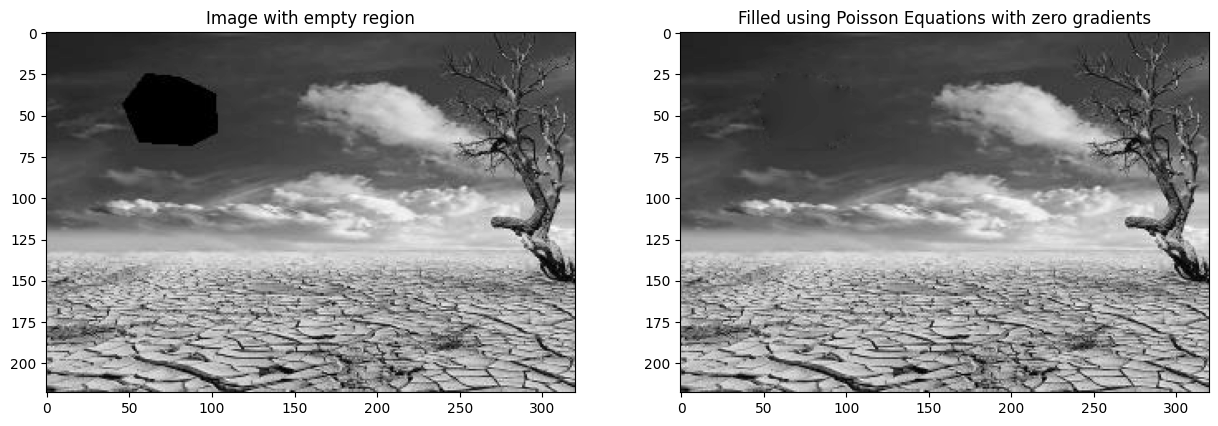

In [6]:
out1=poisson(target_image=smoothHole,mask=smoothMask)

plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.imshow(smoothHole,cmap='gray')
plt.title('Image with empty region')
plt.subplot(1,2,2)
plt.imshow(out1,cmap='gray')
plt.title('Filled using Poisson Equations with zero gradients');
plt.imsave(r'Output/smoothHolePIE.jpg',out1,cmap='gray')
    

#### Filling unknown intensities in high frequency regions

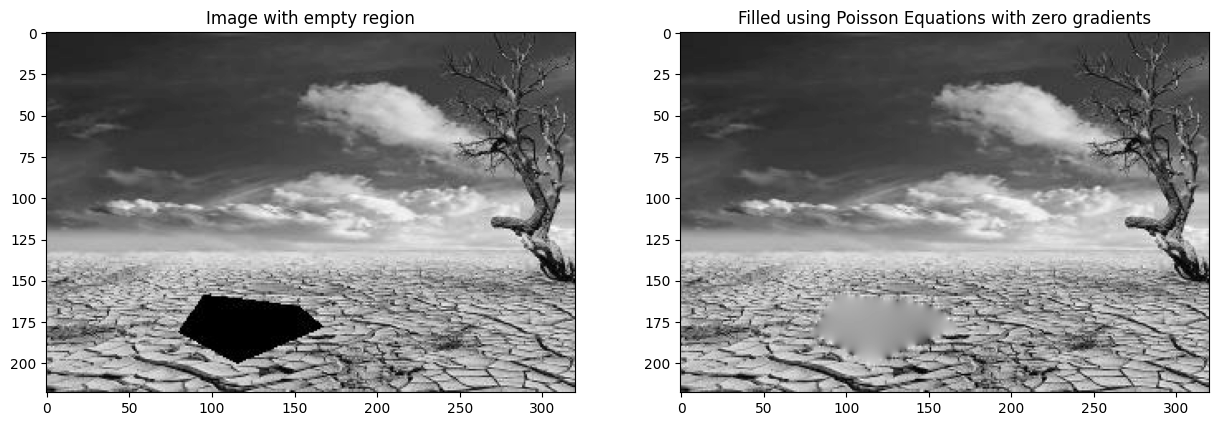

In [7]:
out2=poisson(target_image=HFHole,mask=HFMask)

plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.imshow(HFHole,cmap='gray')
plt.title('Image with empty region')
plt.subplot(1,2,2)
plt.imshow(out2,cmap='gray')
plt.title('Filled using Poisson Equations with zero gradients');

plt.imsave(r'Output/HFHolePIE.jpg',out2,cmap='gray')

#### Filing unknown intensities in large hole

**Note:** As we increase the size of Omega region, 
1. It takes more time for the computation
2. Unless the region is selected in a very smooth region, the filled intensities won't align with the target image
3. The unknown intensities will depend on the pixel values at the border of the unknown region

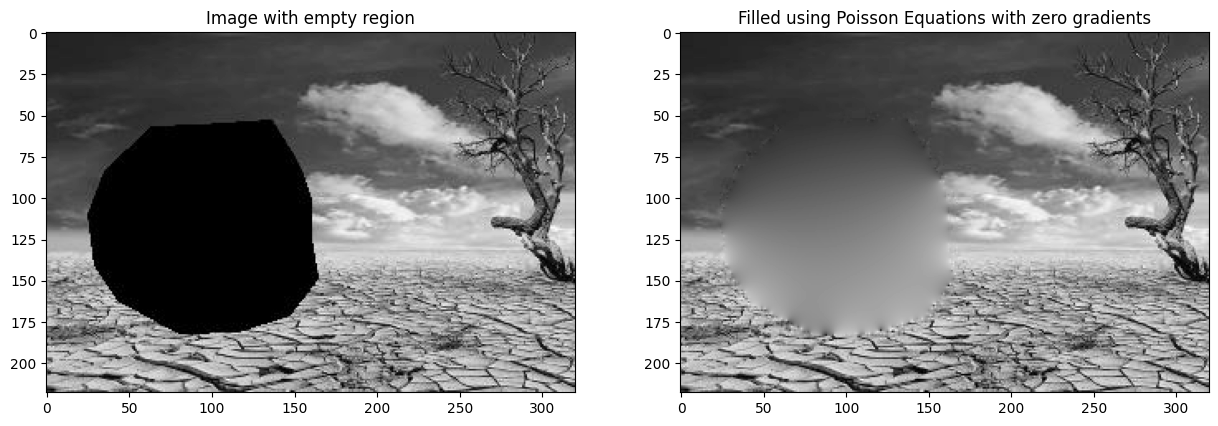

In [8]:
out3=poisson(target_image=LHole,mask=LMask)

plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.imshow(LHole,cmap='gray')
plt.title('Image with empty region')
plt.subplot(1,2,2)
plt.imshow(out3,cmap='gray')
plt.title('Filled using Poisson Equations with zero gradients');

plt.imsave(r'Output/LHolePIE.jpg',out3,cmap='gray')

## Task 2
Now we are ready to try ‘seamless cloning’. The relevant Equations are (9) to (11). Perform both versions (a) importing gradients and (b) mixing gradients. Select images you like to edit and show interesting effects. 


Text(0.5, 1.0, 'Target')

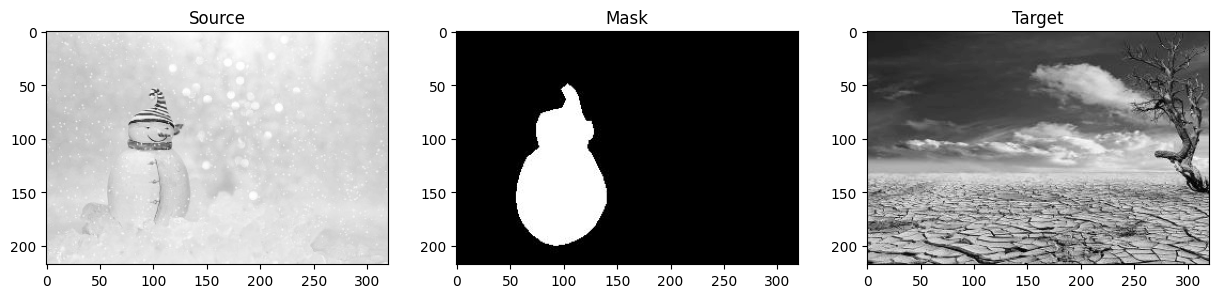

In [9]:
source=cv2.imread('Inputs/snowman.jpg')
source=cv2.cvtColor(source,cv2.COLOR_BGR2GRAY)

mask=cv2.imread('Inputs/snowmanMask.jpg', cv2.IMREAD_GRAYSCALE)

mask[mask < 1] = 0

target=cv2.imread('Inputs/desert1.jpg')
target=cv2.cvtColor(target,cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(15,10))
plt.subplot(1,3,1)
plt.imshow(source,cmap='gray')
plt.title('Source')

plt.subplot(1,3,2)
plt.imshow(mask,cmap='gray')
plt.title('Mask')

plt.subplot(1,3,3)
plt.imshow(target,cmap='gray');
plt.title('Target')

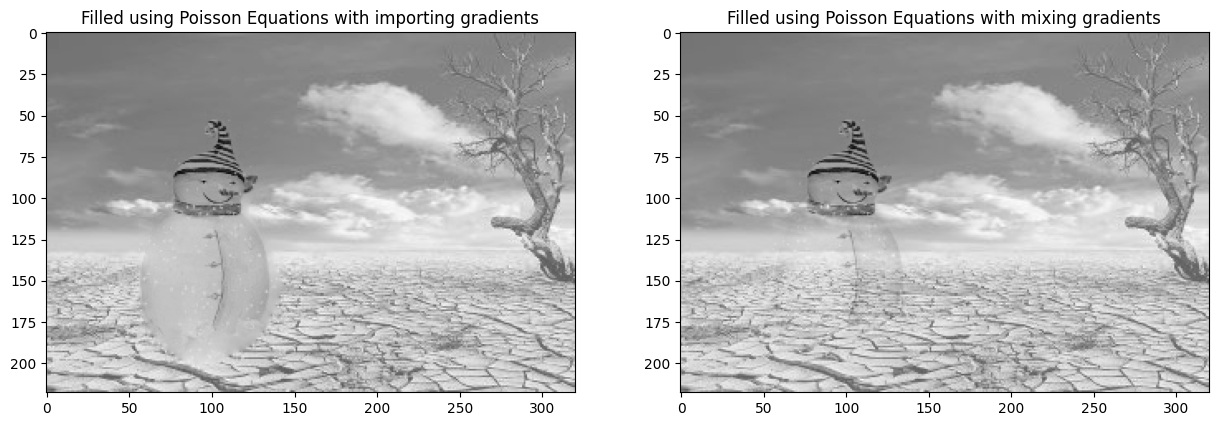

In [10]:
out1=poisson(source_image=source,target_image=target,mask=mask,type='importing_gradients')

plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.imshow(out1,cmap='gray')
plt.title('Filled using Poisson Equations with importing gradients');
plt.imsave(r'Output/desertSnowmanIGray.png',out1,cmap='gray')

out2=poisson(source_image=source,target_image=target,mask=mask,type='mixing_gradients')
plt.subplot(1,2,2)
plt.imshow(out2,cmap='gray')
plt.title('Filled using Poisson Equations with mixing gradients');
plt.imsave(r'Output/desertSnowmanMGray.png',out2,cmap='gray')

In the above images, we can see that the image with Importing gradients has the desired effects. Here we don't desire the gradients from the target image. Let's explore a case where mixing gradients might be desirable

Text(0.5, 1.0, 'Target')

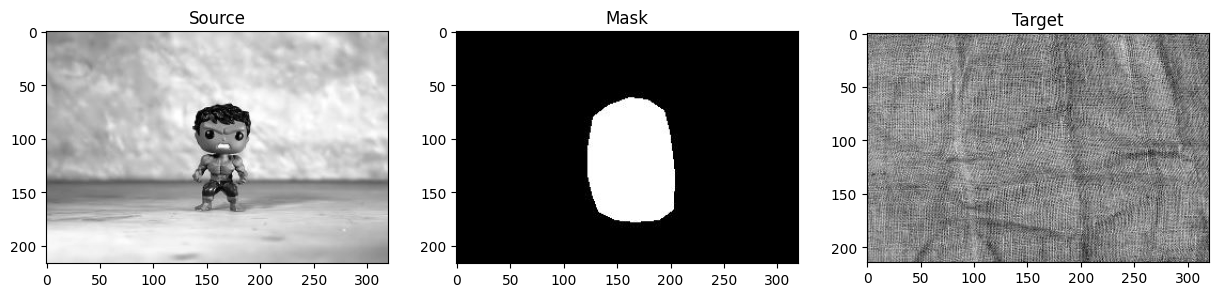

In [11]:
source=cv2.imread('Inputs/hulk.jpg')
source=cv2.cvtColor(source,cv2.COLOR_BGR2GRAY)

mask=cv2.imread('Inputs/hulkMask.jpg', cv2.IMREAD_GRAYSCALE)
# mask,_,_= select_region(source.copy())

# mask[mask < 1] = 0
# plt.imsave('Inputs/hulkMask.jpg',mask,cmap='gray')

target=cv2.imread('Inputs/background.jpg')
target=cv2.cvtColor(target,cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(15,10))
plt.subplot(1,3,1)
plt.imshow(source,cmap='gray')
plt.title('Source')

plt.subplot(1,3,2)
plt.imshow(mask,cmap='gray')
plt.title('Mask')

plt.subplot(1,3,3)
plt.imshow(target,cmap='gray');
plt.title('Target')

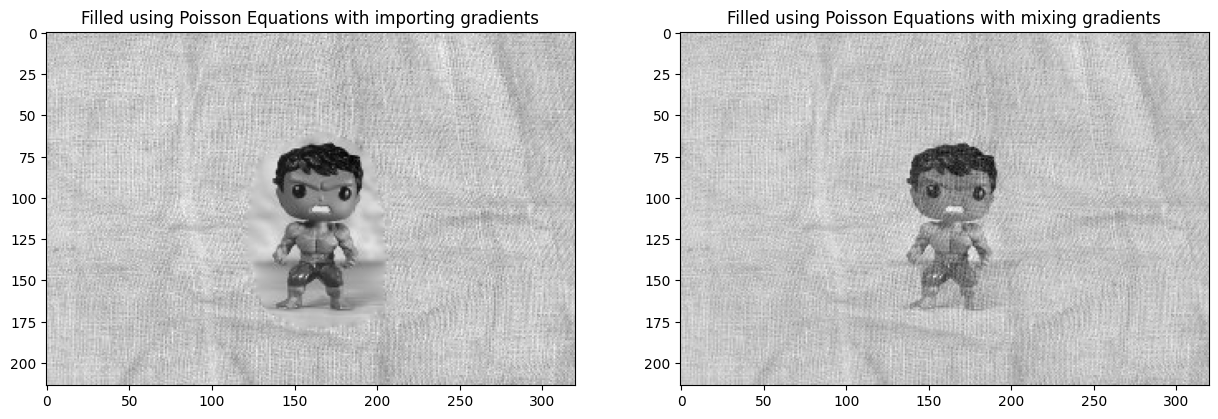

In [12]:
out1=poisson(source_image=source,target_image=target,mask=mask,type='importing_gradients')

plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.imshow(out1,cmap='gray')
plt.title('Filled using Poisson Equations with importing gradients');
plt.imsave(r'Output/hulkIGray.png',out1,cmap='gray')

out2=poisson(source_image=source,target_image=target,mask=mask,type='mixing_gradients')
plt.subplot(1,2,2)
plt.imshow(out2,cmap='gray')
plt.title('Filled using Poisson Equations with mixing gradients');
plt.imsave(r'Output/hulkMGray.png',out2,cmap='gray')

While using mixing gradients, the hulk picture appears as if it has been printed on the canva.The texture of the target image has been retained.

## Task 3
Repeat task 2a for color images. You have to process R, G, B components
separately.


In [13]:
#Let's create a function to perform Poisson Image Editing for 3D images

def poisson3D(target_image,mask,source_image=np.array([]),type='zero_gradients'):
    print('Type:',type)
    result=[]

    for channel in range(target_image.shape[-1]):
        print('Processing Channel:', channel)
        if type=='flatten' or type=='zero_gradients':
            result.append(poisson(target_image=target_image[:,:,channel],mask=mask,type=type))
        else:
            result.append(poisson(source_image=source_image[:,:,channel],target_image=target_image[:,:,channel],mask=mask,type=type))
        print('Completed....')

    image = cv2.merge(result)
    return image

Text(0.5, 1.0, 'Target Image')

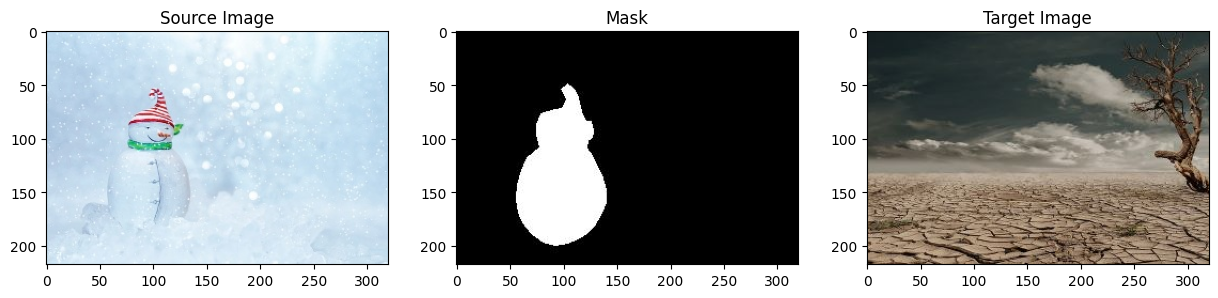

In [14]:
source=cv2.imread('Inputs/snowman.jpg')
source=cv2.cvtColor(source,cv2.COLOR_BGR2RGB)

mask=cv2.imread('Inputs/snowmanMask.jpg', cv2.IMREAD_GRAYSCALE)

mask[mask < 1] = 0

target=cv2.imread('Inputs/desert1.jpg')
target=cv2.cvtColor(target,cv2.COLOR_BGR2RGB)

plt.figure(figsize=(15,10))
plt.subplot(1,3,1)
plt.imshow(source)
plt.title('Source Image')

plt.subplot(1,3,2)
plt.imshow(mask,cmap='gray')
plt.title('Mask')

plt.subplot(1,3,3)
plt.imshow(target);
plt.title('Target Image')

In [15]:
out1=poisson3D(source_image=source,target_image=target,mask=mask,type='importing_gradients')

Type: importing_gradients
Processing Channel: 0
Completed....
Processing Channel: 1
Completed....
Processing Channel: 2
Completed....


In [16]:
out2=poisson3D(source_image=source,target_image=target,mask=mask,type='mixing_gradients')

Type: mixing_gradients
Processing Channel: 0
Completed....
Processing Channel: 1
Completed....
Processing Channel: 2
Completed....


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True

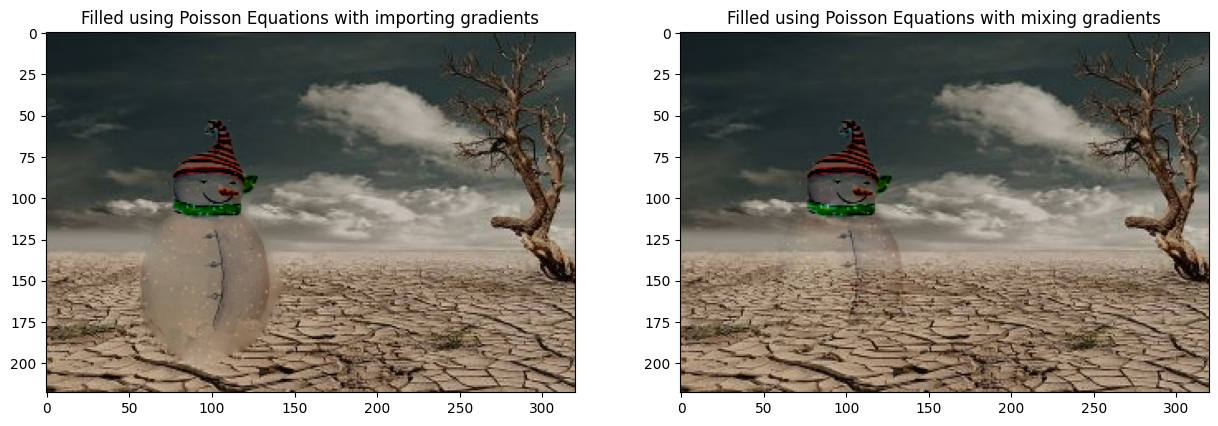

In [17]:
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.imshow(out1,cmap='gray')
plt.title('Filled using Poisson Equations with importing gradients');
r,g,b=cv2.split(out1)
img1=cv2.merge([b,g,r])
cv2.imwrite(r'Output/snowmanIColour.png',img1)

plt.subplot(1,2,2)
plt.imshow(out2,cmap='gray')
plt.title('Filled using Poisson Equations with mixing gradients');
r,g,b=cv2.split(out2)
img2=cv2.merge([b,g,r])
cv2.imwrite(r'Output/snowmanMColour.png',img2)

Text(0.5, 1.0, 'Target Image')

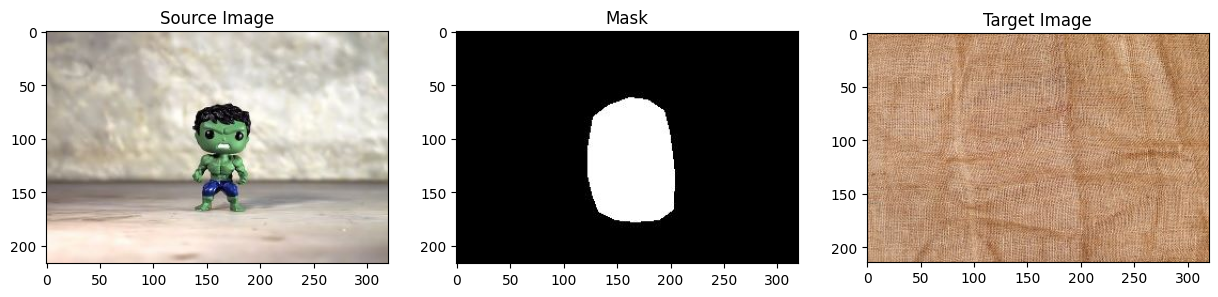

In [18]:
source=cv2.imread('Inputs/hulk.jpg')
source=cv2.cvtColor(source,cv2.COLOR_BGR2RGB)

mask=cv2.imread('Inputs/hulkMask.jpg', cv2.IMREAD_GRAYSCALE)

mask[mask < 1] = 0

target=cv2.imread('Inputs/background.jpg')
target=cv2.cvtColor(target,cv2.COLOR_BGR2RGB)

plt.figure(figsize=(15,10))
plt.subplot(1,3,1)
plt.imshow(source)
plt.title('Source Image')

plt.subplot(1,3,2)
plt.imshow(mask,cmap='gray')
plt.title('Mask')

plt.subplot(1,3,3)
plt.imshow(target);
plt.title('Target Image')

In [19]:
out1=poisson3D(source_image=source,target_image=target,mask=mask,type='importing_gradients')

Type: importing_gradients
Processing Channel: 0
Completed....
Processing Channel: 1
Completed....
Processing Channel: 2
Completed....


In [20]:
out2=poisson3D(source_image=source,target_image=target,mask=mask,type='mixing_gradients')

Type: mixing_gradients
Processing Channel: 0
Completed....
Processing Channel: 1
Completed....
Processing Channel: 2
Completed....


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True

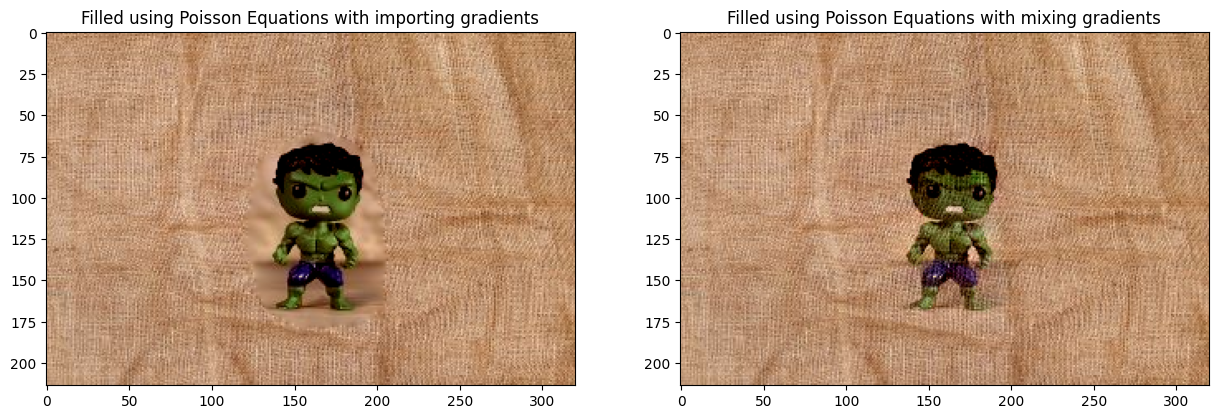

In [21]:
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.imshow(out1,cmap='gray')
plt.title('Filled using Poisson Equations with importing gradients');
r,g,b=cv2.split(out1)
img1=cv2.merge([b,g,r])
cv2.imwrite(r'Output/hulkIColour.png',img1)

plt.subplot(1,2,2)
plt.imshow(out2,cmap='gray')
plt.title('Filled using Poisson Equations with mixing gradients');
r,g,b=cv2.split(out2)
img2=cv2.merge([b,g,r])
cv2.imwrite(r'Output/hulkMColour.png',img2)

## Task 4
Implement only one of the selection editing effects described in Section
4 of the paper. You can decide between: texture flattening, local illumination changes, local colour changes or seamless tiling.


### Texture Flattening

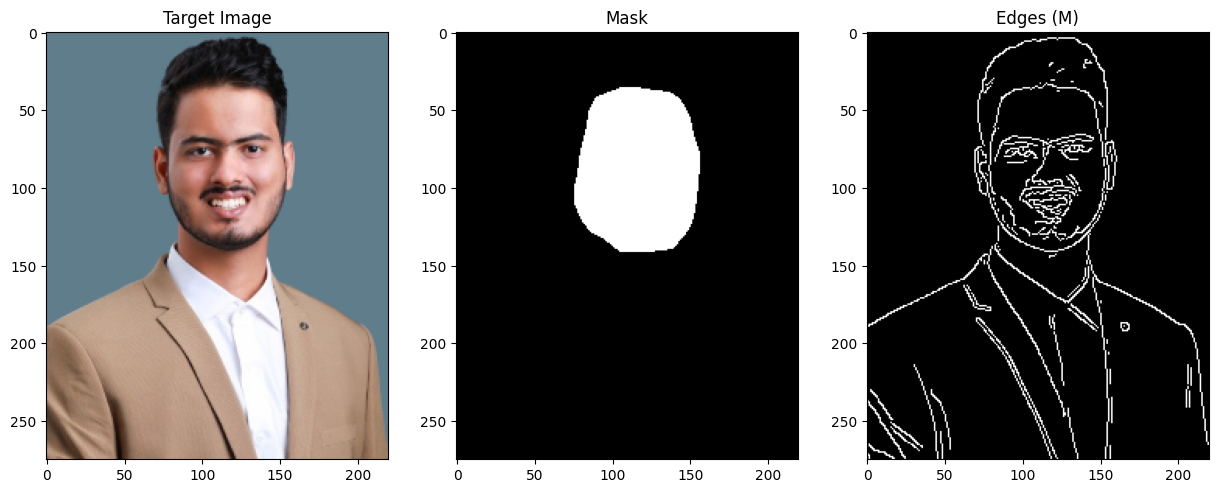

In [22]:
target=cv2.imread('Inputs/sreekar.png')
target=cv2.cvtColor(target,cv2.COLOR_BGR2RGB)

mask=cv2.imread('Inputs/sreekarMask.png', cv2.IMREAD_GRAYSCALE)
# mask,_,_= select_region(target.copy())
mask[mask > 1] = 255
# plt.imsave('Inputs/sreekarMask.png',mask,cmap='gray')

edges=get_edge(target)

plt.figure(figsize=(15,10))
plt.subplot(1,3,1)
plt.imshow(target)
plt.title('Target Image')

plt.subplot(1,3,2)
plt.imshow(mask,cmap='gray')
plt.title('Mask')

plt.subplot(1,3,3)
plt.imshow(edges,cmap='gray');
plt.title(r'Edges (M)');

In [23]:
out=poisson3D(target_image=target,mask=mask,type='flatten')

Type: flatten
Processing Channel: 0
Completed....
Processing Channel: 1
Completed....
Processing Channel: 2
Completed....


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True

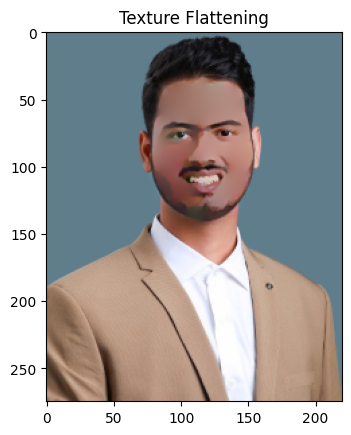

In [24]:
plt.figure()

plt.imshow(out,cmap='gray')
plt.title('Texture Flattening');
r,g,b=cv2.split(out)
img=cv2.merge([b,g,r])
cv2.imwrite(r'Output/sreekarFlat.png',img)